Forged


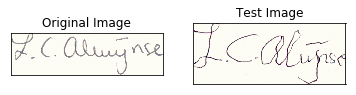

,Item_No,Sample_Flag,area,connected_comps,topleft_x,topleft_y,topright_x,topright_y,bottomleft_x,bottomleft_y,bottomright_x,bottomright_y
0,1,Genuine,0.052021,1.96,0.491417,0.557880,0.599088,0.085098,0.544502,0.782579,0.473066,0.327398
0,1,Test,0.046431,3.00,0.446076,0.515552,0.477698,0.232816,0.307278,0.680283,0.518545,0.305107


In [30]:
import numpy as numpy
from matplotlib import pyplot as matplot
%matplotlib inline
import pandas as pandas
import math
from sklearn import preprocessing
from sklearn import svm
import cv2
import os
os.chdir('D:\Data Science\Python\Signature Verification\Test')

# Loading Image

OriginalImage = cv2.imread('Genuine.png')

Testimage = cv2.imread('Forged.png')
image = cv2.imread('Forged.png')

# Converting Image to Grayscale
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Image pre processing - Convert image into binary, Otsu, Gaussian Blur, Crop image and resize, thin image to get a pixel matrix
# 0 and 1
ret,thresh1 = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(image,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(image,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(image,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(image,127,255,cv2.THRESH_TOZERO_INV)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [image, thresh1, thresh2, thresh3, thresh4, thresh5]

blur = cv2.GaussianBlur(thresh1,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
image=numpy.invert(th3)

def crop_image(img,tol=0):
    mask = img>tol
    return img[numpy.ix_(mask.any(1),mask.any(0))]

cropimage=crop_image(image,tol=0)

def thinning(img):
    #img = cropimage
    size = numpy.size(img)
    skel = numpy.zeros(img.shape,numpy.uint8)

    ret,img = cv2.threshold(img,127,255,0)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    done = False

    while( not done):
        eroded = cv2.erode(img,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(img,temp)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()

        zeros = size - cv2.countNonZero(img)
        if zeros==size:
            done = True

  #  plt.imshow(skel,'gray')
   # plt.show()
    return skel

thinnedimage=thinning(cropimage)

# Feature infusion - 10 Features extracted from signature : Area, Connected components in signature strokes, 
# Centre of Gravity, Area on top left, top right, bottom left ,bottom right in both x and y axis

area=cv2.countNonZero(cropimage)
area=cv2.countNonZero(cropimage)/(cropimage.shape[0]*cropimage.shape[1])

img1=numpy.invert(cropimage)
connectcomp=cv2.connectedComponents(img1)[0]

def coords(thinnedimage):
    rows,cols=thinnedimage.shape
    img_topleft=thinnedimage[0:int(rows/2),0:int(cols/2)]
    img_topright=thinnedimage[int(rows/2)+1:rows,0:int(cols/2)]
    img_bottomleft=thinnedimage[0:int(rows/2),int(cols/2)+1:cols]
    img_bottomright=thinnedimage[int(rows/2)+1:rows,int(cols/2)+1:cols]
    
    topleft_x,topleft_y=COG(img_topleft)
    topright_x,topright_y=COG(img_topright)
    bottomleft_x,bottomleft_y=COG(img_bottomleft)
    bottomright_x,bottomright_y=COG(img_bottomright)

    return topleft_x,topleft_y,topright_x,topright_y,bottomleft_x,bottomleft_y,bottomright_x,bottomright_y



rows,cols=thinnedimage.shape
img_topleft=thinnedimage[0:int(rows/2),0:int(cols/2)]
img_topright=thinnedimage[int(rows/2)+1:rows,0:int(cols/2)]
img_bottomleft=thinnedimage[0:int(rows/2),int(cols/2)+1:cols]
img_bottomright=thinnedimage[int(rows/2)+1:rows,int(cols/2)+1:cols]


def COG(img):
    x_cor=0
    xrun_sum=0
    y_cor=0
    yrun_sum=0
    #print(img.shape)
    for i in range(img.shape[0]):
        x_cor+=sum(img[i])*i/255
        xrun_sum+=sum(img[i])/255

    for i in range(img.shape[1]):
        y_cor+=sum(img[:,i])*i/255
        yrun_sum+=sum(img[:,i])/255
        #print(img.shape[1]) 
        if yrun_sum==0:
            x_pos=0
        else:
            x_pos=y_cor/(yrun_sum)
        if xrun_sum==0:
            y_pos=0
        else:
            y_pos=x_cor/(xrun_sum)
        
   # print(x_pos)
  #  print(y_pos)
    
    return (x_pos/img.shape[1],y_pos/img.shape[0])

# Creating data frame with features for the test data

data = []
i = 1
j = "Test"
thinnedimage=thinning(cropimage)
#Thinning the image!
 
topleft_x,topleft_y,topright_x,topright_y,bottomleft_x,bottomleft_y,bottomright_x,bottomright_y=coords(thinnedimage)
#Extracting features
        
x=pandas.Series([i,j,area,connectcomp,topleft_x,topleft_y,topright_x,topright_y,bottomleft_x,bottomleft_y,bottomright_x,bottomright_y],index=
                    ["Item_No","Sample_Flag","area","connected_comps","topleft_x","topleft_y","topright_x","topright_y","bottomleft_x","bottomleft_y","bottomright_x","bottomright_y"])
data.append(x)
Signature_Table=pandas.DataFrame(data)

# Load original signature for comparison - Features extracted during training data set

Original_Signature = pandas.read_csv("D:\Data Science\Python\Signature Verification\Test\Signature_Table.csv")

# Set tolerance for variance as all genuine signatures may not be exactly same

Tolerance = 0.98

# Created adjusted original signature based on tolerance
Original_Signature[["area","connected_comps","topleft_x","topleft_y","topright_x","topright_y","bottomleft_x","bottomleft_y","bottomright_x","bottomright_y"]] = Original_Signature[["area","connected_comps","topleft_x","topleft_y","topright_x","topright_y","bottomleft_x","bottomleft_y","bottomright_x","bottomright_y"]]*Tolerance

# Compare original signature data against the test data and arrive at the result
Compare = pandas.DataFrame(((Signature_Table >= Original_Signature).loc[0]).value_counts(sort = True)).reset_index()

Compare.columns = ["Match_Flag","Count"]

if Compare.loc[0]["Match_Flag"] == True:
    if Compare.loc[0]["Count"] > 10:
        print("Genuine")
    else:
        print("Forged")
else:
    print("Forged")

titles = ['Original Image','Test Image']
images = [OriginalImage,Testimage]

for i in range(0,2):
    matplot.subplot(1,2,i+1),matplot.imshow(images[i],'gray')
    matplot.title(titles[i])
    matplot.xticks([]),matplot.yticks([])

matplot.show()

Comparison = Original_Signature
Comparison.append(Signature_Table)